# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.0+cu121


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

#### If you are training a neural network for image classification and experiencing underfitting, you might:

- Add more convolutional layers or increase the number of filters in existing layers.
- Include additional features such as color histograms, gradients, or texture descriptors.
- Reduce dropout rate or decrease L2 regularization strength.
- Train for more epochs and use early stopping with a higher patience value.
- Switch to a more complex architecture like ResNet or VGG if using a simple CNN.
- Collect more labeled images or perform data augmentation to increase the dataset size.
- Use transfer learning. Transfer leanring helps to prevent underfitting by leveraging already existing/working patterns from one model/dataset and using them with your own problem.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists.")
else:
  print(f"Couldn't find {image_path} directory, creating...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak, sushi data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Extracting the content  to {image_path}")
  zip_ref.extractall(image_path)

Couldn't find data/pizza_steak_sushi directory, creating...
Extracting the content  to data/pizza_steak_sushi


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(data_path)

There are 1 directories and 1 images in 'data'.
There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [6]:
# Setup train and testing paths
train_path = image_path / "train"
test_path = image_path / "test"

train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

[PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg'), PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'), PosixPath('data/pizza_steak_sushi/train/steak/355715.jpg')]
data/pizza_steak_sushi/train/steak/560503.jpg
steak
Random image path: data/pizza_steak_sushi/train/steak/560503.jpg
Image class: steak
Image height: 512
Image width: 512


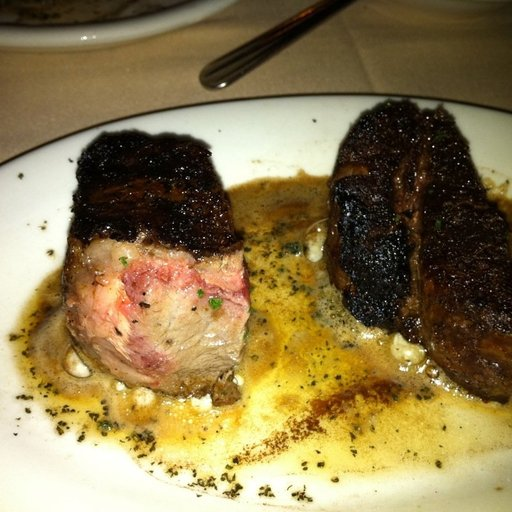

In [7]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:3])

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

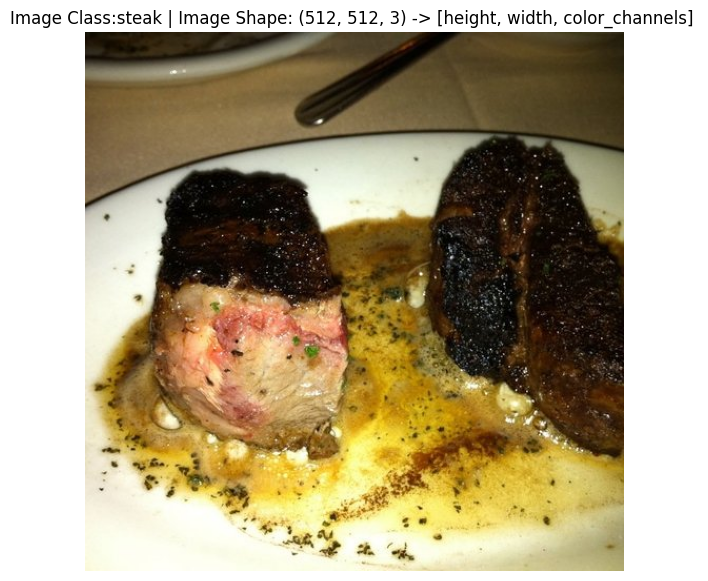

In [8]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt
import numpy as np

# turn image into an array, however, image will also be displayed on colab
img2 = np.asarray(img)
# print(repr(img2))

plt.figure(figsize=(10, 7))
plt.imshow(img2)
plt.title(f"Image Class:{image_class} | Image Shape: {img2.shape} -> [height, width, color_channels] ")
plt.axis(False)


We've got some images in our folders, but before we can use them with PyTorch, we need to convert them into tensors.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),  # due to the architecture we're implementing
    transforms.RandomHorizontalFlip(p=0.5),  # p = probability of flip, 0.5 = 50% chance
    transforms.ToTensor()
])

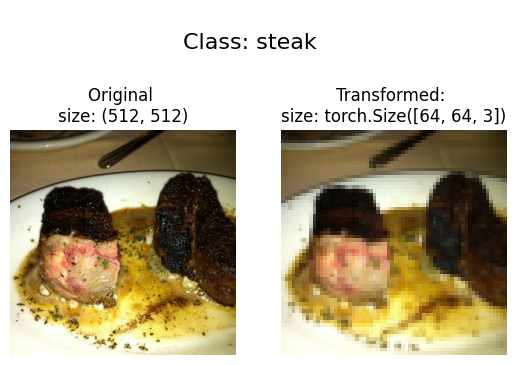

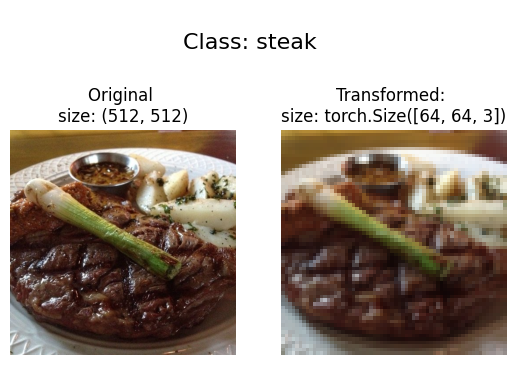

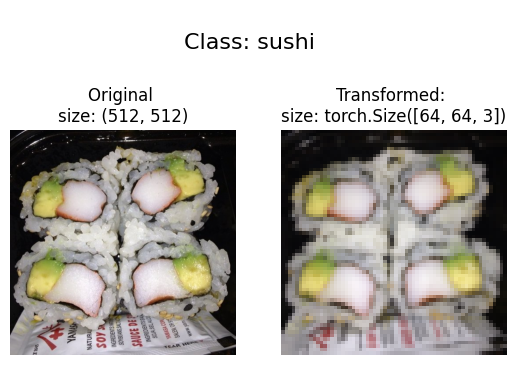

In [11]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nsize: {f.size}")
      ax[0].axis(False)

      tf = transform(f).permute(1, 2, 0)
      ax[1].imshow(tf)
      ax[1].set_title(f"Transformed: \nsize: {tf.shape}")
      ax[1].axis(False)

      fig.suptitle(f"\nClass: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, data_transform)

### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_path,    #BE CAREFUL! enter target folder of images (train or test)
                                  transform=data_transform,
                                  target_transform=None)  # to transform labels (e.g. into one-hot vector etc.)
test_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e80ff3bf490>,
 <torch.utils.data.dataloader.DataLoader at 0x7e80ff3bc5b0>)

In [17]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(225, 75)

In [18]:
img, label = next(iter(train_dataloader))

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [19]:
import torch.nn as nn
import torch

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device) # to ensure that all the model parameters (weights and biases) and any computations are performed on the specified device

#### It is a good practice to test the model and input/output shapes passing dummy data like dummy_x created below:

In [20]:
dummy_x = torch.rand(size=[1, 3, 64, 64])
model_0(dummy_x.to(device))

tensor([[ 0.0174,  0.0599, -0.0247]], grad_fn=<AddmmBackward0>)

## 4. Create training and testing functions for `model_0`.

In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_logits = model(X) # model's raw output logits
    # print(y_logits)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    # Applying softmax along dim=1 ensures that each row (corresponding to a sample in the batch) is
    # transformed independently into a probability distribution over the classes.
    # Each value in the row is scaled so that the sum of the values in each row is 1.
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)  # convert the model's raw output logits to prediction probabilities
    train_acc += (y_pred == y).sum().item() / len(y_pred)
  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_logits, y)
      test_loss += loss.item()  # loss.item() converts the PyTorch tensor containing a single scalar value to a standard Python number (e.g., a float).
      # Calculate and accumulate accuracy
      # Both the logits and the probabilities (from softmax) have the same order of elements,
      # meaning the index of the maximum value in the logits is the same as the index of the maximum value in the probabilities.
      # This means you can directly use argmax on the logits to determine the predicted class, whether for training or testing.
      test_pred_labels = torch.argmax(y_logits, dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [24]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1070 | train_acc: 0.3200 | test_loss: 1.0969 | test_acc: 0.3733
Epoch: 2 | train_loss: 1.1055 | train_acc: 0.3600 | test_loss: 1.1492 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.1078 | train_acc: 0.3333 | test_loss: 1.1040 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.1005 | train_acc: 0.3467 | test_loss: 1.0995 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0993 | train_acc: 0.3467 | test_loss: 1.1000 | test_acc: 0.3333


In [25]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1179 | train_acc: 0.2800 | test_loss: 1.0960 | test_acc: 0.3733
Epoch: 2 | train_loss: 1.1010 | train_acc: 0.3244 | test_loss: 1.0996 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.2933 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0999 | train_acc: 0.3289 | test_loss: 1.1003 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0993 | train_acc: 0.3511 | test_loss: 1.1007 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1011 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0995 | train_acc: 0.3467 | test_loss: 1.1008 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0987 | train_acc: 0.3422 | test_loss: 1.1015 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1021 | test_acc: 0.3333
Epoch: 12 | train_l

In [26]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                             lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1179 | train_acc: 0.2800 | test_loss: 1.0960 | test_acc: 0.3733
Epoch: 2 | train_loss: 1.1010 | train_acc: 0.3244 | test_loss: 1.0996 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0993 | train_acc: 0.2933 | test_loss: 1.0998 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0999 | train_acc: 0.3289 | test_loss: 1.1003 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0993 | train_acc: 0.3511 | test_loss: 1.1007 | test_acc: 0.3333
Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1011 | test_acc: 0.3333
Epoch: 7 | train_loss: 1.0995 | train_acc: 0.3467 | test_loss: 1.1008 | test_acc: 0.3333
Epoch: 8 | train_loss: 1.0987 | train_acc: 0.3422 | test_loss: 1.1015 | test_acc: 0.3333
Epoch: 9 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1014 | test_acc: 0.3333
Epoch: 10 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333
Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1021 | test_acc: 0.3333
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [27]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_3 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(),
                             lr=0.001)

model_3_results = train(model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0995 | train_acc: 0.3689 | test_loss: 1.0825 | test_acc: 0.3467
Epoch: 2 | train_loss: 1.0484 | train_acc: 0.4489 | test_loss: 1.0402 | test_acc: 0.4933
Epoch: 3 | train_loss: 0.9681 | train_acc: 0.5244 | test_loss: 0.9637 | test_acc: 0.4533
Epoch: 4 | train_loss: 0.8791 | train_acc: 0.6178 | test_loss: 0.9756 | test_acc: 0.4800
Epoch: 5 | train_loss: 0.8781 | train_acc: 0.5956 | test_loss: 0.9887 | test_acc: 0.4267
Epoch: 6 | train_loss: 0.8468 | train_acc: 0.6356 | test_loss: 0.9767 | test_acc: 0.4800
Epoch: 7 | train_loss: 0.8403 | train_acc: 0.6400 | test_loss: 1.0069 | test_acc: 0.5067
Epoch: 8 | train_loss: 0.7671 | train_acc: 0.6578 | test_loss: 0.9913 | test_acc: 0.4933
Epoch: 9 | train_loss: 0.7312 | train_acc: 0.6889 | test_loss: 1.0127 | test_acc: 0.4533
Epoch: 10 | train_loss: 0.7279 | train_acc: 0.6844 | test_loss: 1.0202 | test_acc: 0.4533
Epoch: 11 | train_loss: 0.7131 | train_acc: 0.6933 | test_loss: 1.0134 | test_acc: 0.5200
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [28]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [29]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.


Excellent, we now have double the training and testing images...

In [30]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [31]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader



simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                             transform=simple_transform)
test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                            transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent,
                                         batch_size=BATCH_SIZE,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)
test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=BATCH_SIZE,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [32]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_4 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(),
                             lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1046 | train_acc: 0.3200 | test_loss: 1.0870 | test_acc: 0.3867
Epoch: 2 | train_loss: 1.1017 | train_acc: 0.3467 | test_loss: 1.0877 | test_acc: 0.4733
Epoch: 3 | train_loss: 0.9686 | train_acc: 0.5356 | test_loss: 0.9525 | test_acc: 0.5733
Epoch: 4 | train_loss: 0.9032 | train_acc: 0.5978 | test_loss: 0.9081 | test_acc: 0.5667
Epoch: 5 | train_loss: 0.8757 | train_acc: 0.6000 | test_loss: 0.8763 | test_acc: 0.5733
Epoch: 6 | train_loss: 0.8480 | train_acc: 0.6244 | test_loss: 0.8839 | test_acc: 0.5667
Epoch: 7 | train_loss: 0.8411 | train_acc: 0.6156 | test_loss: 0.8780 | test_acc: 0.5733
Epoch: 8 | train_loss: 0.8249 | train_acc: 0.6333 | test_loss: 0.8708 | test_acc: 0.6200
Epoch: 9 | train_loss: 0.7934 | train_acc: 0.6489 | test_loss: 0.8697 | test_acc: 0.6400
Epoch: 10 | train_loss: 0.7683 | train_acc: 0.6711 | test_loss: 0.9077 | test_acc: 0.5733
Epoch: 11 | train_loss: 0.7063 | train_acc: 0.7067 | test_loss: 0.9181 | test_acc: 0.5667
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [56]:
from google.colab import files

uploaded = files.upload()
# with torch.inference_mode():



Saving steak1.jpg to steak1.jpg


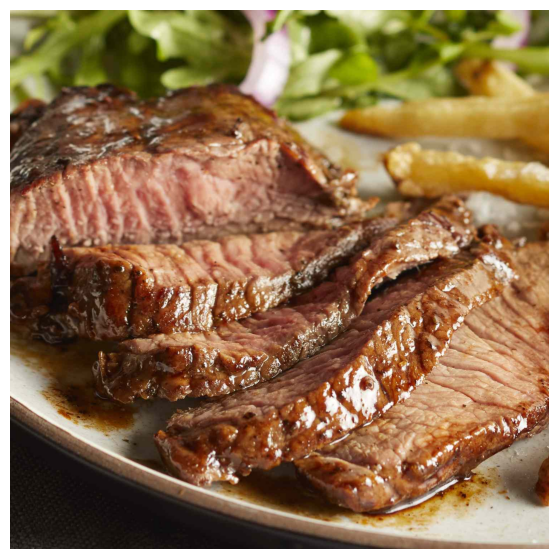

In [57]:
from PIL import Image
import os
import torchvision

# random_img_path = random.choice(image_path_list)
# img1 = Image.open(random_img_path)
# img1

# img2_path = "/content/pizza2.jpg"
img2_path = "/content/steak1.jpg"

# View image 1
# img2 = Image.open(img2_path)
# img2

# View the image 2
img2 = torchvision.io.read_image(img2_path)

img2

plt.figure(figsize=(10, 7))
plt.imshow(img2.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

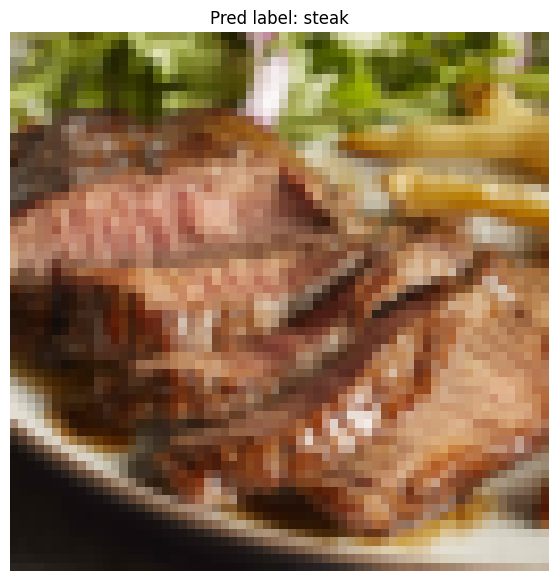

In [58]:
# let's make prediciton
model_4.eval()

with torch.inference_mode():
  img2 = img2 / 255.

  resize = transforms.Resize((64, 64))
  img2 = resize(img2)

  # Turn image in single batch and pass to target device
  batch = img2.unsqueeze(0).to(device)

  y_pred_logit = model_4(batch)

  pred_label = torch.argmax(y_pred_logit, dim=1)

# Plot the image and prediction
plt.figure(figsize=(10, 7))
plt.imshow(img2.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);